In [12]:
from VisualModule import Environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

# Start in the normal way

In [13]:
environment = Environment()

# We can restart the game as usual every parameter will be automaticaly reset

In [14]:
info, reward, state = environment.reset()

# It is integrated with the enviorment so just call simpleCoord
(Action Of The Agent, True if you want to see the image)
It will return the info, reward, coordenates of the agent, coordenates of the enemy.

In this example when players crash the visual module can clearly spot each player.

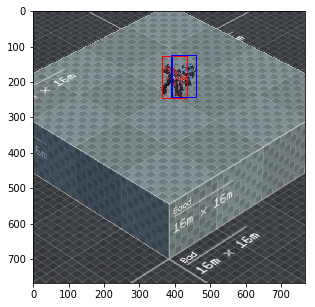

In [15]:
for i in range(78):
    environment.simpleCoord(0,0) 
info, reward, Agent_coord, Enemy_coord=environment.simpleCoord(0,1) 

It will record automaticaly the path of the agent and the enemy in coordenates. Also the rewards, and info (with the typo into)

In [16]:
# environment.Enemy_path, environment.Agent_path, environment.reward_p, environment.into_p

# Now we can use every tool we know directly 
From pands data frames to matplotlib. The trayectory becomes trivial 

(0, 768)

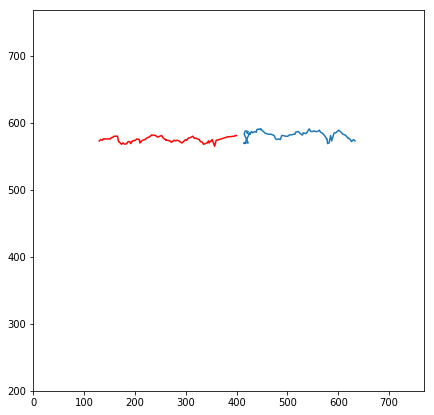

In [17]:
def xyvalues(Agent_path,Enemy_path):
    x_a=[Agent_path[i][0] for i in range(len(Agent_path))]
    # The y axis has to be inverted because of the format
    y_a=[768-Agent_path[i][1] for i in range(len(Agent_path))]
    x_e=[Enemy_path[i][0] for i in range(len(Enemy_path))]
    y_e=[768-Enemy_path[i][1] for i in range(len(Enemy_path))]
    return x_a,y_a,x_e,y_e

x_a,y_a,x_e,y_e = xyvalues(environment.Agent_path,environment.Enemy_path)

plt.rcParams["figure.figsize"] = (7, 7)
plt.plot(x_a,np.array(y_a),color='r')
plt.plot(x_e,np.array(y_e))
plt.ylim(200, 768)
plt.xlim(0, 768)

In [18]:
Game_1 = pd.DataFrame([x_a,y_a,x_e,y_e]).T
Game = Game_1.rename(columns={0: "A_x_comp", 1: "A_y_comp",2: "E_x_comp", 3: "E_y_comp"})
Game.head()
# Every time step in the game can be used

,A_x_comp,A_y_comp,E_x_comp,E_y_comp
0,130,573,633,573
1,133,575,630,575
2,136,574,626,572
3,138,576,623,576
4,143,576,619,577


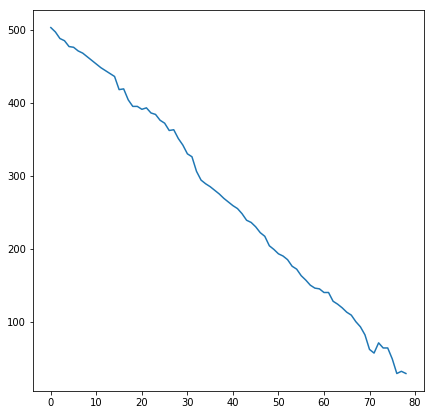

In [19]:
# We can directly plot the distance for exmaple 
plt.plot(np.sqrt(np.square(pd.DataFrame(Game_1[0]-Game_1[2]+Game_1[1]-Game_1[3])).sum(axis=1)))

In [20]:
A_dir=[]
E_dir=[]
Initial_a_dir = [1,0] # By definition they are facing each other
Initial_e_dir = [-1,0]

interval=1 # The interval difference to consider a trayectory 
for i in range(len(Game)-interval):

    Agent_dir = pd.DataFrame(Game.iloc[i]-Game.iloc[i-interval]).iloc[0:2].values
    Enemy_dir = pd.DataFrame(Game.iloc[i]-Game.iloc[i-interval]).iloc[2:4].values
    
    Agent_dir=(Initial_a_dir[0]+normalize(Agent_dir,axis=0)[0][0])/2,(Initial_a_dir[1]+normalize(Agent_dir,axis=0)[1][0])/2
    
    Enemy_dir=(Initial_e_dir[0]+normalize(Enemy_dir,axis=0)[0][0])/2,(Initial_e_dir[1]+normalize(Enemy_dir,axis=0)[1][0])/2

    A_dir.append(Agent_dir)
    E_dir.append(Enemy_dir) # The direction vector is stored in A_dir, E_dir

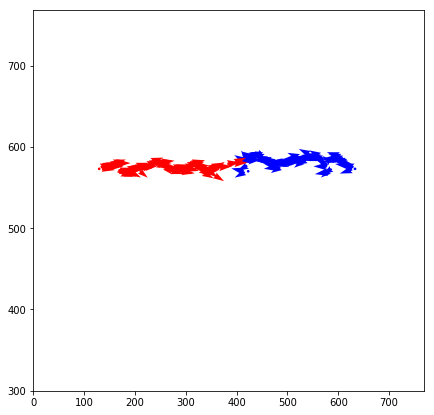

In [21]:

for time in range(len(A_dir)):
    V = np.array([ E_dir[time]])
    origin = Game[["E_x_comp","E_y_comp"]].iloc[time].values[0],Game[["E_x_comp","E_y_comp"]].iloc[time].values[1] # origin point
    plt.quiver(*origin, V[:,0], V[:,1], color=['b'], scale=30)

    VA = np.array([ A_dir[time]])
    origin = Game[["A_x_comp","A_y_comp"]].iloc[time].values[0],Game[["A_x_comp","A_y_comp"]].iloc[time].values[1] # origin point
    plt.quiver(*origin, VA[:,0], VA[:,1], color=['r'], scale=30)

plt.ylim(300, 768)
plt.xlim(0, 768)
plt.show()

This is the visual vector respresentation of the game. Now includes the direction at each time step.

 # With this representation we can start to implement Reinforcement learning--- Run From this cell

In [22]:
# Everything before, but in a function no normalization

def direction(Agent_path,Enemy_path):
    A_X=(Agent_path[-1]-np.array(Agent_path[-2]))[0]
    A_Y=-(Agent_path[-1]-np.array(Agent_path[-2]))[1]
    E_X=(Enemy_path[-1]-np.array(Enemy_path[-2]))[0]
    E_Y=-(Enemy_path[-1]-np.array(Enemy_path[-2]))[1]
    return [A_X,A_Y],[E_X,E_Y]

def fromAction(action):
    info, reward, Agent_coord, Enemy_coord = environment.simpleCoord(action,0)
    if len(environment.Agent_path)<2:
        distance= 500 # Initial distance, kind of irelevant
        Agent_direction=[1,0] # By definition of facing each other
        Enemy_direction=[-1,0]
    else:
        distance = np.sqrt(np.square(np.array(list(np.array(Agent_coord)- np.array(Enemy_coord))).sum(axis=0)))
        # Extract all variables 
        Agent_direction, Enemy_direction  = direction(environment.Agent_path,environment.Enemy_path)

    dir_of_e = np.array(Enemy_coord)-np.array(Agent_coord)
    return info,reward,np.array(Agent_coord),np.array(Enemy_coord),Agent_direction,Enemy_direction,distance,dir_of_e

# In simple terms, for an action of the agent run fromAction(Action) and every feature described will be returned
For example

In [279]:
info, reward, state = environment.reset()

In [280]:
fromAction(0)

(0,
 0,
 array([130, 194]),
 array([633, 191]),
 [1, 0],
 [-1, 0],
 500,
 array([503,  -3]))

# Choose the relevant Features
There are eight variables that will be considered relevant to the agent.
But, we want to minimize the distance, the difference of agent direction and direction of enemy. And maximize reward.

For the most simple model I would use only info, Reward, Agent direction, Distance, Enemy direction. info = 1 means the player has lost and the game should be restarted 

In [281]:
info,reward,_,_,Agent_direction,_,distance,dir_of_e=fromAction(0)
Features=info,reward,Agent_direction,distance,list(dir_of_e)


In [282]:
Features

(0, 0, [3, 1], 497.0, [498, -1])

# Play and Train a simple RL model

In [47]:
Features

(0, [4, 1], 491.0, [492, -1])

In [40]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [34]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

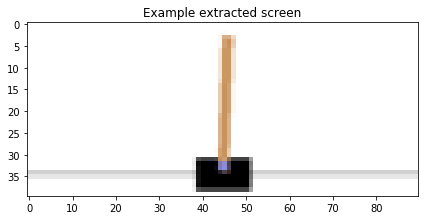

In [35]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [36]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [37]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [39]:
num_episodes = 10
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 504x504 with 0 Axes>

Complete


<Figure size 504x504 with 0 Axes>